# MMP Study Sample Identification
### Which facilities, EPLs, and violations can we use as a part of treatment and comparison groups to evaluate the effect of the MMP program through EPLs?
<i> Ryan Treves

Data:
- `enf_actions_export.csv`: .csv version of 'enf_actions_export.txt'. Flat file containing enforcement records (including EPL issuance dates). Sent to us by Erin Mustain on 2022-03-25 (in email chain w/subject line "RE: Data Work Session with Stanford's RegLab," originally sent to Dan, Maggie, and Nicole).
- `EnfActionToViolationRships.xlsx`: a cross walk between violation and enforcement actions. This is useful to link violations that have multiple enforcement actions. This is provided in an email by Erin to Nicole on Nov 2, 2021. Subject: FW: CIWQS Access for Stanford Researcher.
- `violations_export_2021-10-26.xlsx`: flat file that contains MMP flag and NPDES permit ID. This is similar to `Erin Mustain - violations_export.txt` but with a more recent export time. The file contains all CA water violations since 2000 without filters.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns

# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# display all columns
pd.set_option('display.max_columns', None)

# turn off warning messages
warnings.filterwarnings('ignore')

<i> Read in Data

In [2]:
# Set file paths
data_path = '~/sherlock_oak/EPA/Data/manual/california/'

# Read in data
violations = pd.read_excel(data_path + 'violations_export_2021-10-26.xlsx', dtype={'FACILITY_ID': str})
enforcements = pd.read_csv(data_path + 'enf_actions_export.csv',
                           dtype={'FACILITY ID': object},
                           parse_dates=['DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION', 'EFFECTIVE DATE.1'],
                           date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
enforcements.rename(columns={'FACILITY ID': 'FACILITY_ID'}, inplace=True)
enf_viol_links = pd.read_excel(data_path + 'EnfActionToViolationRships.xlsx', dtype={'Violation ID': object})

In [3]:
# Remove all dismissed violations
violations = violations[violations['STATUS.1'] != 'Dismissed']

### 1. Identify the subset of Expedited Payment Letters (EPLs) that we can use to evaluate the MMP program

In [4]:
# EPL enforcement actions
epl_enforcements = enforcements[
    # Either have a valid ACL issuance date and some mention of an EPL in the enforcement action
    (((enforcements['ENFORCEMENT ACTION TYPE'] == 'Expedited Payment Letter') |
      (enforcements['TITLE'].str.contains('Expedited Payment Letter')) |
      (enforcements['TITLE'].str.contains('EPL'))) &
     (~pd.isna(enforcements['ACL ISSUANCE DATE']))) |

    # Or have a valid EPL issuance date
    (~(pd.isna(enforcements['EPL ISSUANCE DATE'])))
    ]
print(len(epl_enforcements.drop_duplicates('ENFORCEMENT ID (EID)')))
print(len(epl_enforcements.drop_duplicates('FACILITY_ID')))

1384
780


In [5]:
# Use heuristic to estimate EPL date
epl_enforcements['ACL ISSUANCE DATE'] = pd.to_datetime(epl_enforcements['ACL ISSUANCE DATE'], errors='coerce')
epl_enforcements['EPL ISSUANCE DATE'] = pd.to_datetime(epl_enforcements['EPL ISSUANCE DATE'], errors='coerce')
epl_enforcements['estimated_EPL_date'] = epl_enforcements[['EPL ISSUANCE DATE', 'ACL ISSUANCE DATE']].min(axis=1,
                                                                                                          skipna=True)

In [6]:
# Filter out EPLs with no MMP violations
epl_enforcements = epl_enforcements[epl_enforcements['TOTAL MMP VIOLATIONS #'] > 0]
print(len(epl_enforcements.drop_duplicates('ENFORCEMENT ID (EID)')))
print(len(epl_enforcements.drop_duplicates('FACILITY_ID')))

# Remove EPLs that were only drafted, or were withdrawn
valid_epl_enforcements = epl_enforcements[
    epl_enforcements['STATUS.1'].apply(lambda x: x not in list(['Withdrawn', 'Draft']))]
print(len(valid_epl_enforcements.drop_duplicates('ENFORCEMENT ID (EID)')))
print(len(valid_epl_enforcements.drop_duplicates('FACILITY_ID')))

1156
633
1117
615


When were these EPLs sent?

In [7]:
valid_epl_enforcements['ACL ISSUANCE DATE'] = pd.to_datetime(valid_epl_enforcements['ACL ISSUANCE DATE'],
                                                             errors='coerce')
valid_epl_enforcements['EPL ISSUANCE DATE'] = pd.to_datetime(valid_epl_enforcements['EPL ISSUANCE DATE'],
                                                             errors='coerce')
valid_epl_enforcements['estimated_EPL_date'] = valid_epl_enforcements[
    ['EPL ISSUANCE DATE', 'ACL ISSUANCE DATE']].min(axis=1, skipna=True)

In order to eventually evaluate the effect of these EPLs on effluent discharges, we need to link them to the violations that triggered them.

### 2. Link EPLs to violations

In [8]:
epl_viols = enf_viol_links.merge(valid_epl_enforcements, how='right', left_on='Reg Measure ID',
                                 right_on='ENFORCEMENT ID (EID)')
epl_viols.drop('Reg Measure ID', axis=1, inplace=True)
print(len(epl_viols.drop_duplicates('ENFORCEMENT ID (EID)')))
print(len(epl_viols.drop_duplicates('FACILITY_ID')))

1117
615


In [9]:
epl_viols.rename(columns={'Violation ID': 'VIOLATION ID (VID)'}, inplace=True)
epl_viols_merged = epl_viols.merge(violations, on=['VIOLATION ID (VID)'], how='inner')
print(len(epl_viols_merged.drop_duplicates('ENFORCEMENT ID (EID)')))
print(len(epl_viols_merged.drop_duplicates('FACILITY_ID_x')))

1091
610


In [10]:
# Drop non-effluent violations
epl_viols_merged = epl_viols_merged[epl_viols_merged['VIOLATION TYPE'] == 'Effluent']
print(len(epl_viols_merged.drop_duplicates('ENFORCEMENT ID (EID)')))
print(len(epl_viols_merged.drop_duplicates('FACILITY_ID_x')))

# Drop MMP-exempt violations
epl_viols_merged = epl_viols_merged[epl_viols_merged['EXEMPT (Y/N)'] == 'N']
print(len(epl_viols_merged.drop_duplicates('ENFORCEMENT ID (EID)')))
print(len(epl_viols_merged.drop_duplicates('FACILITY_ID_x')))

981
538
981
538


How many EPLs does this represent?

In [11]:
epl_viols_merged.drop_duplicates(subset='ENFORCEMENT ID (EID)').shape

(981, 259)

How many facilities does this represent?

In [12]:
epl_viols_merged.drop_duplicates(subset='FACILITY_ID_x').shape

(538, 259)

Test: Do we have any violations corresponding to the same EPL that produce conflicting estimated EPL dates?

In [13]:
EPL_date_test = epl_viols_merged.groupby('ENFORCEMENT ID (EID)').nunique()[['estimated_EPL_date']]
len(EPL_date_test[EPL_date_test['estimated_EPL_date'] > 1])

0

How many facilities do we have just from 2008?

In [14]:
pd.Series((epl_viols_merged.drop_duplicates(subset='FACILITY_ID_x', keep='first')['estimated_EPL_date'] > pd.to_datetime(
    '2008-01-01')) &
          (epl_viols_merged.drop_duplicates(subset='FACILITY_ID_x', keep='first')['estimated_EPL_date'] < pd.to_datetime(
              '2009-01-01'))).value_counts()

False    434
True     104
Name: estimated_EPL_date, dtype: int64

How many violations is this?

In [15]:
len(epl_viols_merged[(epl_viols_merged['estimated_EPL_date'] < pd.to_datetime('2009-01-01')) &
                     (epl_viols_merged['estimated_EPL_date'] > pd.to_datetime('2008-01-01'))])

2153

What is the temporal distribution of EPLs between 2008 and 2010?

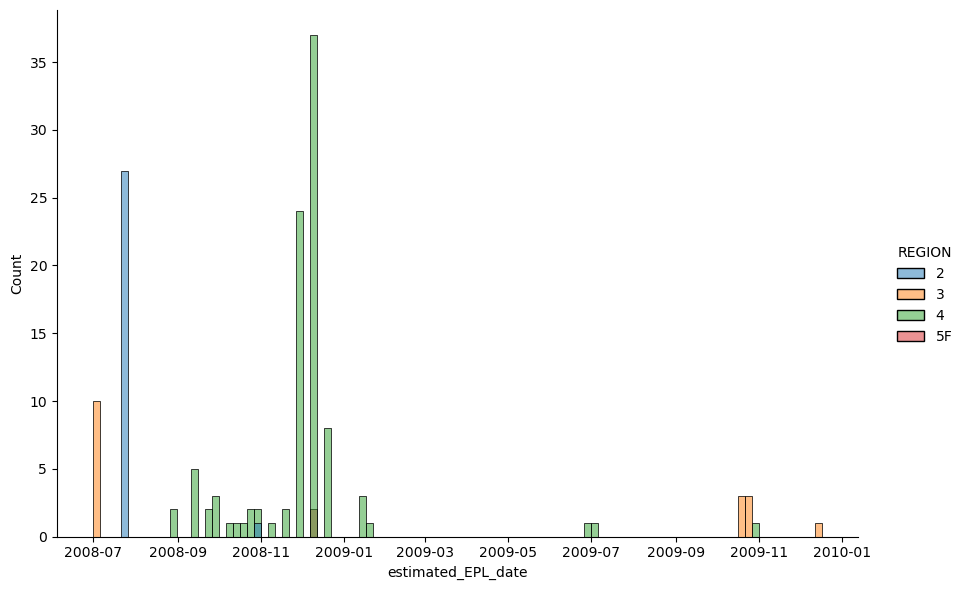

In [16]:
plt.style.use('default')
sns.displot(epl_viols_merged.drop_duplicates('ENFORCEMENT ID (EID)')[(epl_viols_merged.drop_duplicates(
    'ENFORCEMENT ID (EID)')['estimated_EPL_date'] > pd.to_datetime('2008-01-01')) & (epl_viols_merged.drop_duplicates(
    'ENFORCEMENT ID (EID)')['estimated_EPL_date'] < pd.to_datetime('2010-01-01'))], x='estimated_EPL_date',
            hue='REGION', height=6, aspect=6 / 4, bins=104)

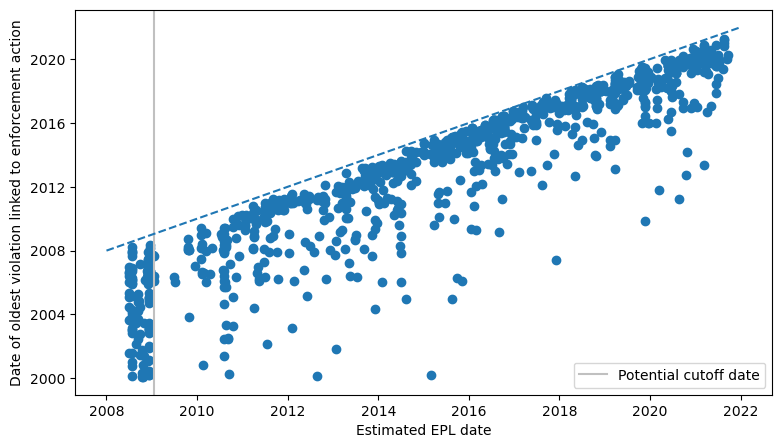

In [17]:
plt.style.use('default')
plt.figure(figsize=(9, 5))
plt.scatter(epl_viols_merged.drop_duplicates('ENFORCEMENT ID (EID)')['estimated_EPL_date'],
            epl_viols_merged.drop_duplicates('ENFORCEMENT ID (EID)')[
                'DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION'])
plt.axvline(x=pd.to_datetime('2009-01-22'), color='silver', label='Potential cutoff date')
plt.plot([pd.to_datetime('2008-01-01'), pd.to_datetime('2022-01-01')],
         [pd.to_datetime('2008-01-01'), pd.to_datetime('2022-01-01')], linestyle='--')
plt.ylabel('Date of oldest violation linked to enforcement action')
plt.xlabel('Estimated EPL date')
plt.legend()

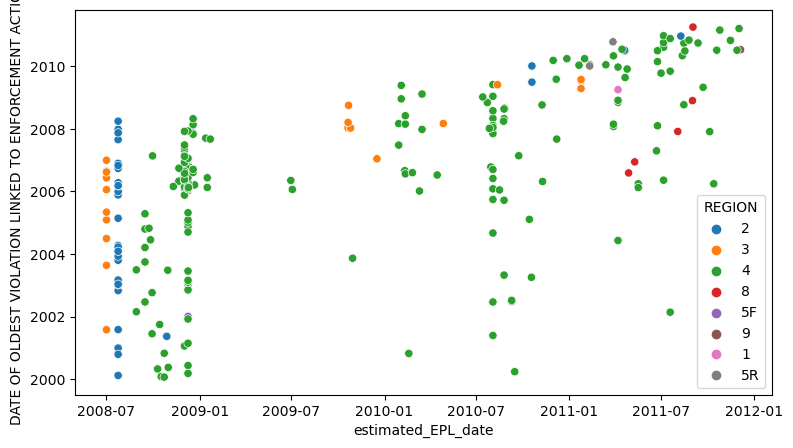

In [18]:
plt.style.use('default')
plt.figure(figsize=(9, 5))
sns.scatterplot(data=epl_viols_merged.drop_duplicates('ENFORCEMENT ID (EID)')[
    (epl_viols_merged.drop_duplicates('ENFORCEMENT ID (EID)')['estimated_EPL_date'] > pd.to_datetime('2008-01-01')) & (
            epl_viols_merged.drop_duplicates('ENFORCEMENT ID (EID)')['estimated_EPL_date'] < pd.to_datetime(
        '2012-01-01'))], x='estimated_EPL_date', y='DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION',
                hue='REGION');
#plt.savefig('EPLs_by_date_region', dpi=300)

How many facilities would we have with a cutoff date of 2009-01-22?

In [19]:
len(epl_viols_merged[epl_viols_merged['estimated_EPL_date'] <= pd.to_datetime('2009-01-22')].drop_duplicates(
    'FACILITY_ID_x'))

135

What if we excluded facilities that were sent an EPL within the time period that was withdrawn?

In [20]:
withdrawn = epl_enforcements[(epl_enforcements['STATUS.1'] == 'Withdrawn') & (
        epl_enforcements['estimated_EPL_date'] <= pd.to_datetime('2009-01-22'))]
withdrawn_facilities = list(withdrawn['FACILITY_ID'].unique())

In [21]:
treatment_EPL_viols = epl_viols_merged[(epl_viols_merged['estimated_EPL_date'] <= pd.to_datetime('2009-01-22')) & (
    epl_viols_merged['FACILITY_ID_x'].apply(lambda x: x not in withdrawn_facilities))]
print(len(treatment_EPL_viols.drop_duplicates('ENFORCEMENT ID (EID)')))
print(len(treatment_EPL_viols.drop_duplicates('FACILITY_ID_x')))

133
133


How many linked violations?

In [22]:
len(treatment_EPL_viols)

1521

A few steps back, we merged enforcements and violations on VIOLATION ID (VID). Are there conflicts between the FACILITY_ID variable in the enforcements and violations table?

In [23]:
treatment_EPL_viols[treatment_EPL_viols['FACILITY_ID_x'] != treatment_EPL_viols['FACILITY_ID_y']][['FACILITY_ID_x', 'FACILITY NAME_x', 'FACILITY_ID_y', 'FACILITY NAME_y']]

,FACILITY_ID_x,FACILITY NAME_x,FACILITY_ID_y,FACILITY NAME_y
9,218402,Ox Mountain Class III Landfill,215718,Corinda Los Trancos Landfll
10,218402,Ox Mountain Class III Landfill,215718,Corinda Los Trancos Landfll
11,218402,Ox Mountain Class III Landfill,215718,Corinda Los Trancos Landfll
12,218402,Ox Mountain Class III Landfill,215718,Corinda Los Trancos Landfll
13,218402,Ox Mountain Class III Landfill,215718,Corinda Los Trancos Landfll
14,218402,Ox Mountain Class III Landfill,215718,Corinda Los Trancos Landfll
15,218402,Ox Mountain Class III Landfill,215718,Corinda Los Trancos Landfll
16,218402,Ox Mountain Class III Landfill,215718,Corinda Los Trancos Landfll
5701,246616,Ojai Valley WWTP,NaN,NaN
5702,246616,Ojai Valley WWTP,NaN,NaN


The Ox Mountain Sanitary Landfill "is constructed within the Corinda Los Trancos Canyon, and has also historically been referred to as the Corinda Los Trancos (Ox Mountain) Landfill." (source: https://www.waterboards.ca.gov/sanfranciscobay/board_info/agendas/2018/November/OxMountain/Tentative_Order.pdf)
The Raymond A. Boege Alvarado WWTP is permitted to discharge under the EBDA common outfall (https://www.waterboards.ca.gov/sanfranciscobay/board_info/agendas/2017/May/EBDA/EBDA_Tentative_Order.pdf)
Thus, it looks like FACILITY_NAME_x and FACILITY_NAME_y conflicts are not of concern.


Did the treatment group get any MMP enforcements before the 2008 MMP enforcement push?

In [24]:
treatment_facilities = treatment_EPL_viols['FACILITY_ID_x'].unique()

In [25]:
treatment_mmp_enforcements = enforcements[(enforcements['FACILITY_ID'].apply(lambda x: x in treatment_facilities)) & (enforcements['TOTAL MMP VIOLATIONS #'] > 0)]

treatment_mmp_enforcements_pre2008 = treatment_mmp_enforcements[
    treatment_mmp_enforcements['EFFECTIVE DATE.1'] < pd.to_datetime('2008-07-01')]

In [26]:
pre_treated = treatment_mmp_enforcements_pre2008['FACILITY_ID'].unique()
len(pre_treated)

60

It appears that 60 facilities in our treatment group were subject to MMP-related enforcement actions before the 2008 state MMP enforcement push. What sort of enforcement actions are these?

In [27]:
treatment_mmp_enforcements_pre2008

,REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,FACILITY TYPE,AGENCY TYPE,# OF AGENCIES,PLACE ADDRESS,PLACE CITY,PLACE ZIP,PLACE COUNTY,PLACE LATITUDE,PLACE LONGITUDE,SIC CODE 1,SIC DESC 1,SIC CODE 2,SIC DESC 2,SIC CODE 3,SIC DESC 3,NAICS CODE 1,NAICS DESC 1,NAICS CODE 2,NAICS DESC 2,NAICS CODE 3,NAICS DESC 3,# OF PLACES,SOURCE OF FACILITY,DESIGN FLOW,THREAT TO WATER QUALITY,COMPLEXITY,PRETREATMENT,FACILITY WASTE TYPE,FACILITY WASTE TYPE 2,FACILITY WASTE TYPE 3,FACILITY WASTE TYPE 4,PROGRAM,PROGRAM CATEGORY,# OF PROGRAMS,WDID,REG MEASURE ID,REG MEASURE TYPE,REGION.1,ORDER #,NPDES # CA#,MAJOR-MINOR,NPDES TYPE,RECLAMATION,DREDGE FILL FEE,301H,APPLICATION FEE AMT RECEIVED,STATUS,STATUS DATE,EFFECTIVE DATE,EXPIRATION/REVIEW DATE,TERMINATION DATE,WDR REVIEW - AMEND,WDR REVIEW - REVISE/RENEW,WDR REVIEW - RESCIND,WDR REVIEW - NO ACTION REQUIRED,WDR REVIEW - PENDING,WDR REVIEW - PLANNED,STATUS ENROLLEE,INDIVIDUAL/GENERAL,FEE CODE,STAFF ASSIGNED,# OF STAFF ASSIGNED,SUPERVISOR,# OF SUPERVISORS,DIRECTION/VOICE,ENFORCEMENT ID (EID),REGION.2,ORDER / RESOLUTION NUMBER,ENFORCEMENT ACTION TYPE,EFFECTIVE DATE.1,ADOPTION / ISSUANCE DATE,ACHIEVE DATE,TERMINATION DATE.1,ACL ISSUANCE DATE,EPL ISSUANCE DATE,STATUS.1,TITLE,DESCRIPTION,PROGRAM.1,PROGRAM CATEGORY.1,# OF PROGRAMS.1,ASSIGNED STAFF,# OF ASSIGNED STAFF,SUPERVISOR.1,# OF SUPERVISORS.1,LATEST MILESTONE COMPLETION DATE,TOTAL ASSESSMENT AMOUNT,INITIAL ASSESSED AMOUNT,LIABILITY $ AMOUNT,PROJECT $ AMOUNT,LIABILITY $ PAID,PROJECT $ COMPLETED,TOTAL $ PAID/COMPLETED AMOUNT,AGENCY ISSUING ENF,DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION,RANK 1 VIOLATIONS,RANK 2 VIOLATIONS,RANK 3 VIOLATIONS,UNCLASSIFIED VIOLATIONS,ATOX VIOLATIONS #,BMP VIOLATIONS #,BASIN PLAN PROHIBITION VIOLATIONS #,CAT1 VIOLATIONS #,CAT2 VIOLATIONS #,CTOX VIOLATIONS #,DEFICIENT MONITORING VIOLATIONS #,DEFICIENT REPORT VIOLATIONS #,ENFORCEMENT ACTION VIOLATIONS #,FEES VIOLATIONS #,GROUNDWATER VIOLATIONS #,HYDRO MODIFICATION VIOLATIONS #,LATE REPORT VIOLATIONS #,OEV VIOLATIONS #,OTHER CODES VIOLATIONS #,PERMIT CONDITION VIOLATIONS #,PRETREATMENT VIOLATIONS #,REPORTING FAILURE TO NOTIFY VIOLATIONS #,SSO VIOLATIONS #,SURFACE WATER VIOLATIONS #,SWPPP VIOLATIONS #,UNAUTHORIZED DISCHARGE VIOLATIONS #,PRIORITY VIOLATIONS,TOTAL MMP VIOLATIONS #,EFFLUENT MMP SERIOUS,CHRONIC MMP,REPORTING MMP SERIOUS,TOTAL # OF VIOLATIONS LINKED TO THIS ENFORCEMENT ACTION,ECONOMIC BENEFIT,STAFF COST,MAXIMUM POTENTIAL LIABILITY
547,2,259507,Sunnyvale WPCP,Sunnyvale City,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,1.0,1444 Borregas Avenue,Sunnyvale,94089,Santa Clara,37.418900,-122.016060,4952.0,Sewerage Systems,NaN,NaN,NaN,NaN,22132.0,Sewage Treatment Facilities,NaN,NaN,NaN,NaN,1.0,Reg Meas,29.500000,1.0,A,Y - POTW has EPA approved pretreatment program,Domestic wastewater,NaN,NaN,NaN,NPDMUNILRG,NPDESWW,1.0,2 438018001,142258.0,NPDES Permits,2,98-053,CA0037621,Major,MUN,N - No,NaN,N,NaN,Historical,6/17/98,6/17/98,6/17/03,8/19/03,NaN,NaN,NaN,NaN,NaN,NaN,N,I,NaN,Linda Rao,1.0,NaN,NaN,Passive,221953,2,R2-2001-0085,Admin Civil Liability,2001-08-20,NaN,8/20/01,NaN,NaN,NaN,Historical,Enforcement - 2 438018001,5 viol 3 CN daily max 1 TBT daily max 1 TBT mo...,NPDMUNILRG,NPDESWW,1.0,NaN,NaN,NaN,NaN,11/15/02,15000.0,NaN,12000.00,3000.00,12000.00,3000.0,15000.00,NaN,2000-06-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,1.0,0.0,4,NaN,NaN,NaN
548,2,259507,Sunnyvale WPCP,Sunnyvale City,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,1.0,1444 Borregas Avenue,Sunnyvale,94089,Santa Clara,37.418900,-122.016060,4952.0,Sewerage Systems,NaN,NaN,NaN,NaN,22132.0,Sewage Treatment Facilities,NaN,NaN,NaN,NaN,1.0,Reg Meas,29.500000,1.0,A,Y - POTW has EPA approved pretreatment program,Domestic wastewater,NaN,NaN,NaN,NPDMUNILRG,NPDESWW,1.0,2 438018001,142258.0,NPDES Permits,2,98-053,CA0037621,Major,MUN,N - No,NaN,N,NaN,Historical,6/17/98,6/

In [28]:
treatment_mmp_enforcements_pre2008[['EFFECTIVE DATE.1', 'LIABILITY $ AMOUNT', 'PROJECT $ AMOUNT', 'TOTAL $ PAID/COMPLETED AMOUNT', 'TOTAL MMP VIOLATIONS #', 'TOTAL # OF VIOLATIONS LINKED TO THIS ENFORCEMENT ACTION']].describe()

,LIABILITY $ AMOUNT,PROJECT $ AMOUNT,TOTAL $ PAID/COMPLETED AMOUNT,TOTAL MMP VIOLATIONS #,TOTAL # OF VIOLATIONS LINKED TO THIS ENFORCEMENT ACTION
count,76.000000,61.000000,91.000000,183.000000,183.000000
mean,25192.963289,19910.406393,33089.727582,38.557377,44.081967
std,47545.625914,30550.764907,57066.257262,229.781013,230.357364
min,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3000.000000,3000.000000,3000.000000,2.000000,3.000000
50%,12000.000000,6000.000000,12000.000000,5.000000,10.000000
75%,27000.000000,24000.000000,34500.000000,14.000000,21.500000
max,350000.000000,139500.000000,350000.000000,2882.000000,2889.000000


In [29]:
treatment_mmp_enforcements_pre2008['REGION'].value_counts(normalize=True)

4    0.442623
2    0.360656
3    0.196721
Name: REGION, dtype: float64

In [30]:
treatment_mmp_enforcements_pre2008['ENFORCEMENT ACTION TYPE'].value_counts(normalize=True)

Admin Civil Liability           0.513661
Notice of Violation             0.327869
Oral Communication              0.136612
13267 Letter                    0.010929
Formal Refer to Attorney Gen    0.005464
Settlement - Court Order        0.005464
Name: ENFORCEMENT ACTION TYPE, dtype: float64

## Treatment group definition A:
Facilities which received an EPL in 2008-2009 during the state MMP enforcement push, and had never received an MMP-related enforcement before the push (not `pre_treated`).

In [31]:
treatment_facilities = treatment_EPL_viols[treatment_EPL_viols['FACILITY_ID_x'].apply(lambda x: x not in pre_treated)]['FACILITY_ID_x'].unique()
# Save facilities to disk
pd.Series(treatment_facilities).to_csv('/Users/rtreves/Documents/RegLab/python_projects/ca_mmp/policy_eval/groups/treatment_A_facilities.csv')

In [32]:
treatment_violations_all = violations[(violations['FACILITY_ID'].apply(lambda x: x in treatment_facilities))]

### Identify comparison group A for treatment group A:

How many NPDES facilities had MMP-nonexempt effluent violations before 2008 but either (a) never received an EPL or (b) received their first EPL after 01/22/2009?

In [33]:
# Define the list of CA SWRCB programs including NPDES permittees. Drawn from NL's work in `ca_exploratory_analysis_NL.ipynb`
npdes_programs = ['DODNPDESSW', 'DODNPDESWW', 'NPDESWW', 'NPDINDLRG', 'NPDINDSML', 'NPDMINING', 'NPDMUNILRG',
                  'NPDMUNIOTH', 'NPDNONMUNIPRCS']

# Treatment group plus those that received an EPL in 2008-2009 that was withdrawn
exclude_facilities = list(treatment_EPL_viols['FACILITY_ID_x'].unique()) + withdrawn_facilities

comparison_violations = violations[(violations['PROGRAM'].apply(lambda x: x in npdes_programs)) &
                                   (violations['VIOLATION TYPE'] == 'Effluent') &
                                   (violations['OCCURRED ON'] < pd.to_datetime('2008-07-01')) &
                                   (violations['EXEMPT (Y/N)'] == 'N') &
                                   (violations['FACILITY_ID'].apply(lambda x: x not in exclude_facilities))]
len(comparison_violations.drop_duplicates(subset='FACILITY_ID'))

862

What is the distribution of pre-2008 violations of all types (e.g., including non-MMP violations and reporting violations) in this comparison group compared to our treatment group?

In [34]:
comparison_facilities = comparison_violations['FACILITY_ID'].unique()
comparison_violations_all = violations[violations['FACILITY_ID'].apply(lambda x: x in comparison_facilities)]

What facility-level differences do we see between the two groups?

In [35]:
# This function takes in a comparison group, treatment group, and a column name,
# and returns the top n values of the column in order of the absolute difference
# in composition of the two groups. Streamlines compositional analysis.
def compare_composition(data_a, data_b, column, top_n=3):
    A = pd.DataFrame(data_a[column].value_counts(normalize=True)).rename(columns={column: 'Comparison'})
    B = pd.DataFrame(data_b[column].value_counts(normalize=True)).rename(columns={column: 'Treatment'})
    results = pd.concat([A, B], axis=1)
    results['diff'] = np.abs(results['Comparison'] - results['Treatment'])
    results = results.apply(lambda x: x.round(2))
    results.sort_values(by='diff', inplace=True, ascending=False)
    results = results.reset_index(names='Value').set_index(pd.Index([column] * len(results)))
    return results.head(top_n)

In [36]:
facility_results = pd.DataFrame()
for column in ['AGENCY TYPE', 'PROGRAM', 'MAJOR-MINOR', 'VIOLATED FACILITY REGION']:
    facility_results = pd.concat([facility_results, compare_composition(comparison_violations_all.drop_duplicates('FACILITY_ID'),
                    treatment_violations_all.drop_duplicates('FACILITY_ID'), column)])
facility_results.sort_values(by='diff', ascending=False, inplace=True)
facility_results

,Value,Comparison,Treatment,diff
VIOLATED FACILITY REGION,4,0.42,0.85,0.43
PROGRAM,NPDNONMUNIPRCS,0.49,0.66,0.17
MAJOR-MINOR,Minor,0.75,0.86,0.11
MAJOR-MINOR,Major,0.25,0.14,0.11
PROGRAM,NPDMUNIOTH,0.09,0.01,0.08
PROGRAM,NPDMUNILRG,0.16,0.10,0.07
AGENCY TYPE,City Agency,0.18,0.12,0.05
AGENCY TYPE,County Agency,0.05,0.10,0.05
AGENCY TYPE,Privately-Individual,0.00,0.03,0.03
VIOLATED FACILITY REGION,3,0.05,0.01,0.03


What enforcements did facilities in the comparison group receive pre-2008?

In [37]:
comparison_enforcements = comparison_violations_all[
    comparison_violations_all['OCCURRED ON'] < pd.to_datetime('2008-07-01')].merge(enf_viol_links,
                                                                                   left_on='VIOLATION ID (VID)',
                                                                                   right_on='Violation ID',
                                                                                   how='left').merge(enforcements,
                                                                                                     left_on='Reg Measure ID',
                                                                                                     right_on='ENFORCEMENT ID (EID)',
                                                                                                     how='left')
comparison_enforcements_pre2008 = comparison_enforcements[
    comparison_enforcements['EFFECTIVE DATE.1'] < pd.to_datetime('2008-07-01')]
comparison_enforcements_pre2008.head(20)

,VIOLATED FACILITY REGION,REGULATED FACILITY REGION,FACILITY_ID_x,FACILITY NAME_x,AGENCY NAME_x,PLACE TYPE_x,PLACE SUBTYPE_x,FACILITY TYPE_x,AGENCY TYPE_x,NUMBER OF AGENCIES,PLACE ADDRESS_x,PLACE CITY_x,PLACE ZIP_x,PLACE COUNTY_x,PLACE LATITUDE_x,PLACE LONGITUDE_x,SIC CODE 1_x,SIC DESC 1_x,SIC CODE 2_x,SIC DESC 2_x,SIC CODE 3_x,SIC DESC 3_x,NAICS CODE 1_x,NAICS DESC 1_x,NAICS CODE 2_x,NAICS DESC 2_x,NAICS CODE 3_x,NAICS DESC 3_x,NUMBER OF PLACES,DESIGN FLOW_x,THREAT TO WATER QUALITY_x,COMPLEXITY_x,PRETREATMENT_x,FACILITY WASTE TYPE_x,FACILITY WASTE TYPE 2_x,FACILITY WASTE TYPE 3_x,FACILITY WASTE TYPE 4_x,PROGRAM_x,PROGRAM CATEGORY_x,NUMBER OF PROGRAMS,WDID_x,REG MEASURE ID_x,REG MEASURE TYPE_x,TITLE_x,DESCRIPTION_x,ORDER NUMBER,NPDES# CA#,MAJOR-MINOR_x,NPDES TYPE_x,RECLAMATION_x,DREDGE FILL FEE_x,301H_x,APPLICATION FEE AMT RECEIVED_x,STATUS_x,STATUS DATE_x,EFFECTIVE DATE_x,EXPIRATION/REVIEW DATE_x,TERMINATION DATE_x,ADOPTION DATE,WDR REVIEW - AMEND_x,WDR REVIEW - REVISE/RENEW_x,WDR REVIEW - RESCIND_x,WDR REVIEW - NO ACTION REQUIRED_x,WDR REVIEW - PENDING_x,WDR REVIEW - PLANNED_x,STATUS ENROLLEE_x,INDIVIDUAL/GENERAL_x,FEE CODE_x,STAFF ASSIGNED_x,NUMBER OF STAFF ASSIGNED,SUPERVISOR_x,NUMBER OF SUPERVISORS,VIOLATION ID (VID),VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,VIOLATION COMMENTS,CORRECTIVE ACTION,STATUS.1_x,OCCURRED ON,DISCOVERY DATE,PROGRAM.1_x,PROGRAM CATEGORY.1_x,PRIORITY (Y/N),NPDES Serious (Y/N),Otherwise MMP (Y/N),EXEMPT (Y/N),Reason Exempt from MMPs,MMP TYPE,QNCR Reportable,Violation Source,Violation Source ID,Violation Rank,Parameter,Limit,Result,Units,Period,Monitoring Location,Number of Final (A+H) 13267,Number of Final (A+H) 13308,Number of Final (A+H) ACL,Number of Final (A+H) CDO,Number of Final (A+H) CAO,Number of Final (A+H) Expedited Payment Letters,Number of Final (A+H) Referrals to Attorney General,Number of Final (A+H) Notices of Stormwater Noncompliance,Number of Final (A+H) Notices of Violation,Number of Final (A+H) Notices to Comply,Number of Final (A+H) Oral Communications,Number of Final (A+H) Referrals to District Attorney,Number of Final (A+H) Referrals to Other Agency,Number of Final (A+H) Referrals to Task Force,Number of Final (A+H) Referrals to USEPA,Number of Final (A+H) Settlement Court Orders,Number of Final (A+H) Staff Enforcement Letter,Number of Final (A+H) Stipulated Penalties,Number of Final (A+H) Third Party Actions,Number of Final (A+H) Time Schedule Orders,Number of Final (A+H) Unknown,Number of Final (A+H) Waste Discharge Requirements,Reg Measure ID,Violation ID,Effective Date,REGION,FACILITY_ID_y,FACILITY NAME_y,AGENCY NAME_y,PLACE TYPE_y,PLACE SUBTYPE_y,FACILITY TYPE_y,AGENCY TYPE_y,# OF AGENCIES,PLACE ADDRESS_y,PLACE CITY_y,PLACE ZIP_y,PLACE COUNTY_y,PLACE LATITUDE_y,PLACE LONGITUDE_y,SIC CODE 1_y,SIC DESC 1_y,SIC CODE 2_y,SIC DESC 2_y,SIC CODE 3_y,SIC DESC 3_y,NAICS CODE 1_y,NAICS DESC 1_y,NAICS CODE 2_y,NAICS DESC 2_y,NAICS CODE 3_y,NAICS DESC 3_y,# OF PLACES,SOURCE OF FACILITY,DESIGN FLOW_y,THREAT TO WATER QUALITY_y,COMPLEXITY_y,PRETREATMENT_y,FACILITY WASTE TYPE_y,FACILITY WASTE TYPE 2_y,FACILITY WASTE TYPE 3_y,FACILITY WASTE TYPE 4_y,PROGRAM_y,PROGRAM CATEGORY_y,# OF PROGRAMS,WDID_y,REG MEASURE ID_y,REG MEASURE TYPE_y,REGION.1,ORDER #,NPDES # CA#,MAJOR-MINOR_y,NPDES TYPE_y,RECLAMATION_y,DREDGE FILL FEE_y,301H_y,APPLICATION FEE AMT RECEIVED_y,STATUS_y,STATUS DATE_y,EFFECTIVE DATE_y,EXPIRATION/REVIEW DATE_y,TERMINATION DATE_y,WDR REVIEW - AMEND_y,WDR REVIEW - REVISE/RENEW_y,WDR REVIEW - RESCIND_y,WDR REVIEW - NO ACTION REQUIRED_y,WDR REVIEW - PENDING_y,WDR REVIEW - PLANNED_y,STATUS ENROLLEE_y,INDIVIDUAL/GENERAL_y,FEE CODE_y,STAFF ASSIGNED_y,# OF STAFF ASSIGNED,SUPERVISOR_y,# OF SUPERVISORS,DIRECTION/VOICE,ENFORCEMENT ID (EID),REGION.2,ORDER / RESOLUTION NUMBER,ENFORCEMENT ACTION TYPE,EFFECTIVE DATE.1,ADOPTION / ISSUANCE DATE,ACHIEVE DATE,TERMINATION DATE.1,ACL ISSUANCE DATE,EPL ISSUANCE DATE,STATUS.1_y,TITLE_y,DESCRIPTION_y,PROGRAM.1_y,PROGRAM CATEGORY.1_y,# OF PR

In [38]:
comparison_enforcements_pre2008['ENFORCEMENT ACTION TYPE'].value_counts(normalize=True)

Admin Civil Liability           0.411141
Notice of Violation             0.264280
Cease and Desist Order          0.122922
Staff Enforcement Letter        0.087640
Oral Communication              0.067219
Time Schedule Order             0.019258
Settlement - Court Order        0.009104
13267 Letter                    0.006920
Notice to Comply                0.003630
Referral to Task Force          0.003630
Clean-up and Abatement Order    0.002553
Referral to Other Agency        0.000851
Expedited Payment Letter        0.000454
Formal Refer to Attorney Gen    0.000340
Waste Discharge Requirements    0.000028
Referral to USEPA               0.000028
Name: ENFORCEMENT ACTION TYPE, dtype: float64

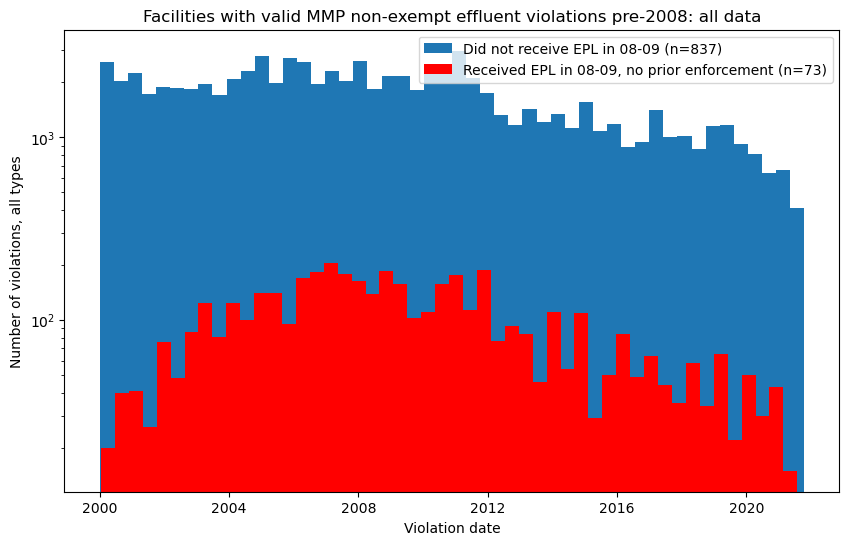

In [39]:
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.hist(data=comparison_violations_all, x='OCCURRED ON', log=True, label='Did not receive EPL in 08-09 (n=837)',
         bins=50);
plt.hist(data=treatment_violations_all, x='OCCURRED ON', log=True, color='red',
         label='Received EPL in 08-09, no prior enforcement (n=73)', bins=50);
plt.xlabel('Violation date')
plt.ylabel('Number of violations, all types')
plt.title('Facilities with valid MMP non-exempt effluent violations pre-2008: all data')
plt.legend();

### Can we find a comparison group B of facilities for which MMP was consistently enforced before 2008?

In [40]:
mmp_enforcements = enforcements[(enforcements['TOTAL MMP VIOLATIONS #'] > 0) &
                                (enforcements['EFFECTIVE DATE.1'] < pd.to_datetime('2008-07-01')) &
                                (enforcements['STATUS.1'] != 'Withdrawn')].groupby('FACILITY_ID', as_index=False).sum()[
    ['FACILITY_ID', 'TOTAL MMP VIOLATIONS #']]
mmp_enforcements.rename(columns={'TOTAL MMP VIOLATIONS #': 'MMP violation enforcement instances pre-2008'},
                        inplace=True)

Due to the difficulty of accounting for instances where a single violation is linked to multiple enforcement actions, here we define enforcement rate as the sum of the number of  MMP violations linked to pre-2008 enforcements (`TOTAL MMP VIOLATIONS #`, 'MMP violation enforcement instances') divided by the number of pre-2008 MMP violations. Thus, the enforcement rate can exceed 1 when a violation is enforced multiple times.

In [41]:
mmp_violations = violations[(~pd.isna(violations['MMP TYPE'])) &
                            (violations['OCCURRED ON'] < pd.to_datetime('2008-07-01'))].groupby('FACILITY_ID',
                                                                                                as_index=False).nunique()[
    ['FACILITY_ID', 'VIOLATION ID (VID)']]
mmp_violations.rename(columns={'VIOLATION ID (VID)': 'Total # pre-2008 MMP violations'}, inplace=True)

In [42]:
mmp_enforcement_rates = mmp_enforcements.merge(mmp_violations, on='FACILITY_ID')
mmp_enforcement_rates['enf_rate'] = mmp_enforcement_rates['MMP violation enforcement instances pre-2008'] / \
                                    mmp_enforcement_rates['Total # pre-2008 MMP violations']

Sanity check: are any of these facilities appearing in our treatment group?

In [43]:
len(mmp_enforcement_rates[mmp_enforcement_rates['FACILITY_ID'].apply(lambda x: x in treatment_facilities)])

0

In [44]:
mmp_enforcement_rates.sort_values(by=['enf_rate'], ascending=False).head(10)

,FACILITY_ID,MMP violation enforcement instances pre-2008,Total # pre-2008 MMP violations,enf_rate
112,229725,467.0,11,42.454545
114,229967,25.0,5,5.000000
194,251069,4.0,1,4.000000
303,271054,933.0,234,3.987179
266,260531,178.0,49,3.632653
268,260702,101.0,28,3.607143
56,215961,110.0,35,3.142857
302,270849,168.0,54,3.111111
239,256964,9.0,3,3.000000
198,252211,18.0,6,3.000000


Excluding our outlier, what does the distribution of these enforcement rates look like?

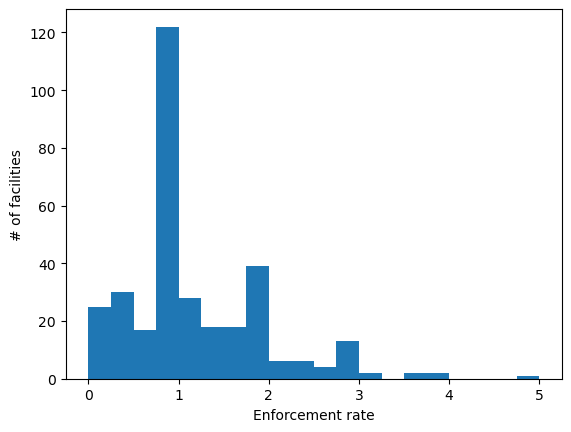

In [45]:
plt.hist(mmp_enforcement_rates[mmp_enforcement_rates['FACILITY_ID'] != '229725']['enf_rate'], bins=20);
plt.xlabel('Enforcement rate')
plt.ylabel('# of facilities');

Let's define this new comparison group by an enforcement rate > 0.75:

In [46]:
comparison_facilities_B = list(mmp_enforcement_rates[mmp_enforcement_rates['enf_rate'] > 0.75]['FACILITY_ID'])
# Save facilities to disk
pd.Series(comparison_facilities_B).to_csv('/Users/rtreves/Documents/RegLab/python_projects/ca_mmp/policy_eval/groups/comparison_B_facilities.csv')
comparison_violations_all_B = violations[violations['FACILITY_ID'].apply(lambda x: x in comparison_facilities_B)]

## Zooming out: when did facilities get their first brush with MMP enforcement?

In [47]:
mmp_enforcements_all = enforcements[(enforcements['TOTAL MMP VIOLATIONS #'] > 0) &
                                (enforcements['STATUS.1'] != 'Withdrawn')]
mmp_enforcements_all['REGION 2/3/4'] = mmp_enforcements_all['REGION'].apply(lambda x: x in ['2', '3', '4'])

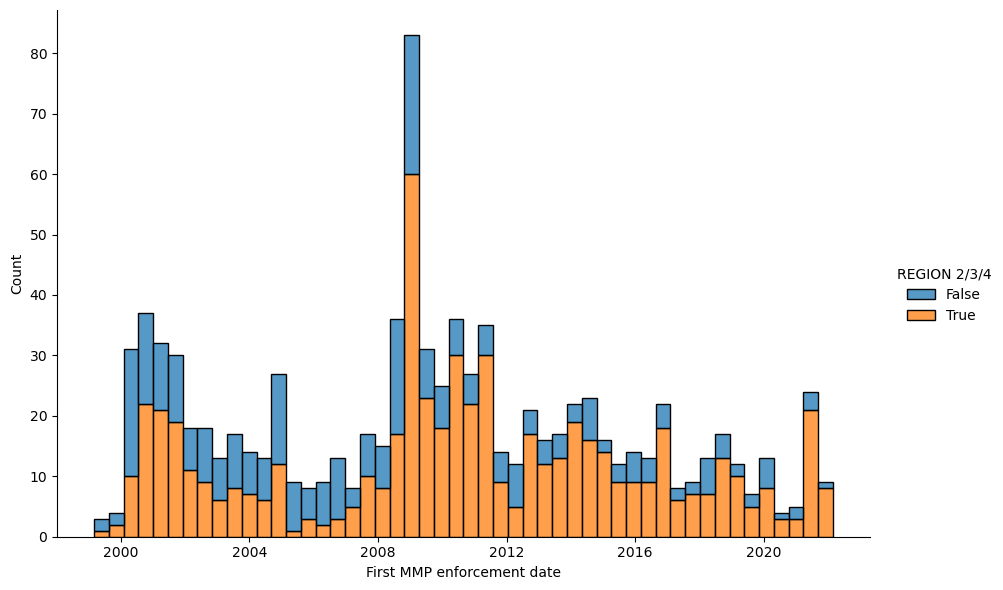

In [48]:
plt.style.use('default')
sns.displot(data=mmp_enforcements_all.groupby('FACILITY_ID', as_index=False).min(), x='EFFECTIVE DATE.1', hue='REGION 2/3/4', bins=50, height=6, aspect=6 / 4, multiple='stack');
plt.xlabel('First MMP enforcement date');

In [49]:
first_enforcements = mmp_enforcements_all.groupby('FACILITY_ID', as_index=False).min()[['FACILITY_ID', 'EFFECTIVE DATE.1']].rename(columns={'EFFECTIVE DATE.1': 'First enforcement'})

test = violations.merge(first_enforcements, on='FACILITY_ID')
test['Years since first enf'] = test['OCCURRED ON'].dt.year - test['First enforcement'].dt.year
test_viol_rate = test.groupby(['FACILITY_ID', 'Years since first enf'], as_index=False).nunique()[['FACILITY_ID', 'Years since first enf', 'VIOLATION ID (VID)']]

In [50]:
test_viol_rate = test_viol_rate.groupby('Years since first enf', as_index=False).agg(mean_viol_count=pd.NamedAgg(column='VIOLATION ID (VID)', aggfunc=lambda x: x.mean()), se=pd.NamedAgg(column='VIOLATION ID (VID)', aggfunc=lambda x: x.sem()))

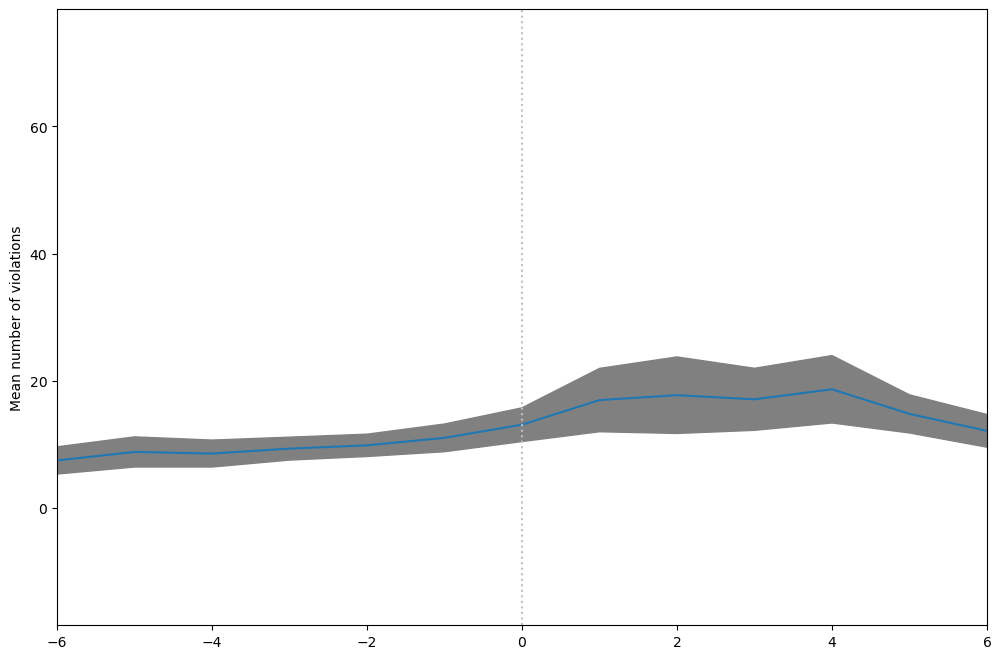

In [51]:
plt.figure(figsize=(12,8))

plt.plot(test_viol_rate['Years since first enf'], test_viol_rate['mean_viol_count']);
plt.fill_between(test_viol_rate['Years since first enf'], test_viol_rate['mean_viol_count']-(2*test_viol_rate['se']), test_viol_rate['mean_viol_count']+(2*test_viol_rate['se']), color='gray')
plt.xlim([-6, 6])
plt.ylabel('Mean number of violations')
plt.axvline(x=0, linestyle=':', color='silver');